# Project 12: Spatial fairness in urban environments <br>

In [1]:
import geopandas as gpd
import folium
import numpy as np
import networkx as nx 
import pandas as pd
import itertools
import warnings
import sumolib
import os
#import openrouteservice as ors
from sklearn.preprocessing import MinMaxScaler

from shapely.geometry import LineString, Point

import warnings
warnings.filterwarnings("ignore")

from plot_utils import edges_to_gps_list, plot_paths, plot_bar_paths_cost
from routing_utils import from_sumo_to_igraph_network
from routing_algorithms import *
import matplotlib.pyplot as plt

attribute = 'traveltime'

### Utility <br>
Functions to improve readability

In [2]:
# modified version of the function of GiulianoCornacchia from the github,
# the only change is that the returned dataframe has one column for the edge id and one column for the geometry
def gdf_from_sumo_network(sumo_road_network, crs="EPSG:4326", edge_list=None):
    edges_to_plot = sumo_road_network.getEdges()
        
    list_line_strings = []
    list_ids = [] 

    for edge in edges_to_plot: 
        list_ids.append(edge.getID())      
        edge_gps_list = [sumo_road_network.convertXY2LonLat(x[0], x[1]) for x in edge.getShape()]
        list_line_strings.append(LineString(edge_gps_list))

    df_net = gpd.GeoDataFrame(data = list_ids, geometry=list_line_strings, crs="EPSG:4326") 

    df_net.columns = ['id', 'geometry']
    return df_net 

In [3]:
# function to print the correct row for the file xml
# path: tuple/list of edges
# i: identifier for the row
# type: type of trip, in this case if it is toward the city center or towards a random edge
# return: row ready to be written in the file
def path_to_xml(path, i, type):
    edges = ''
    depart = np.random.randint(0, 200)

    for e in path:
        edges+= str(e.getID()) + ' '

    s = '<vehicle id="'+type+str(i)+'" type="veh_passenger" depart="0" departLane="best"> <route edges="'+ edges +'"/> </vehicle> '
    return s

# function to print the correct row for the file xml
# path: list of edges ids
# i: identifier for the row
# type: type of trip, in this case if it is toward the city center or towards a random edge
# return: row ready to be written in the file
def list_to_xml(path, i, type):
    edges = ''
    depart = np.random.randint(0, 200)

    for e in path:
        edges+= str(e) + ' '

    s = '<vehicle id="'+type+str(i)+'" type="veh_passenger" depart="0" departLane="best"> <route edges="'+ edges +'"/> </vehicle> '
    return s

In [4]:
# create a blank map for the city of Leuven
def Leuven_map():
    point = (50.849738563227824, 4.644786576420597)
    m = folium.Map(location=point, zoom_start = 12)
    return m

m = Leuven_map()

The first step of the project was the data preparation. <br>
In this first part I opened three datasets:
* The real hub configuration, the locations of all mobility hubs in Leuven where mobility services are clustered together.
* The administrative zones of Leuven, GIS file with the sectors (identified by parameter CODSEC).
* The road network generated with SUMO

Then, some preliminary operations are performed. For each dataset I kept only the 'important' attributes, generally this means <br>
geometry, identifier and, in the case of the road network, the edge id.

## Data

In [5]:
# Open the hubs dataframe
url = 'https://storageaccount11111111.blob.core.windows.net/container1/Leuven/hub_data_leuven/mobility_hubs.gpkg'
hubs = gpd.read_file(url).to_crs('epsg:4326')[['nr', 'naam punt', 'geometry']]
folium.GeoJson(hubs).add_to(m)

In [6]:
# Open the zone dataframe
zones_leuven = gpd.read_file('https://storageaccount11111111.blob.core.windows.net/container1/Leuven/socio_demographic_data/leuven_statsec.gpkg')
zones_leuven = zones_leuven.to_crs('epsg:4326')[['CODSEC', 'geometry']]
folium.GeoJson(zones_leuven).add_to(m)

In [7]:
# road network from the sumo network
#
# build the network, the gdf and the graph directly from the sumo configuration
net = sumolib.net.readNet(os.getcwd()+'/Sumo/osm.net.xml')
road_net = gdf_from_sumo_network(net)
G = from_sumo_to_igraph_network(net)

Some operations were done on the dataframes.<br>

First, for each road it's useful to have its zone, so I performed a spatial join and retrieve only the street associated with a zone.<br>
For the pourpose of the project the dimension of the dataset it's enough that the simulation are statistically significant, but in <br>
future update one way is to infer new zones, *using clustering algorithm for example, and discard no streets.* <br>

Then, the opposite, it's easier to have only the zones with at least one represented road, so I decided to drop from the zones dataframe the ones without a road. <br>

In the hub dataframe, I decided to perform once again the spatial join, to retrieve its zone, and add the nearest edge in the SUMO net.<br>
In this way I can save computation time, since the possible starting points are aready computed. I decided to set a threshold in the <br>
searching of the nearest edge, and hubs with no edges in that radius are discarded from the dataset.

Lastly, I decided to extract, for each zone, its neighbors. Since one of the task is to retrieve the time needed for a user to exit from the neighborhood, <br>
it's easier to have a list of the adjecent zones ready at the use, and create flows between a zone and one of its neighbors.

In [8]:
road_net = road_net.sjoin(zones_leuven, how = 'inner')[['id', 'geometry', 'CODSEC']]

In [9]:
hubs = hubs.sjoin(zones_leuven, how = 'inner')[['nr', 'geometry', 'CODSEC']]
hubs.reset_index(inplace=True, drop = True)

In [10]:
#Popolate the geodataframe assigning, for each hub, its nearest edge in the SUMO network
nearest_edge = []

for idx, row in hubs.iterrows():
    hub = row['geometry']
    
    #nearest neighbouring edge of the hubs
    x_o, y_o = net.convertLonLat2XY(hub.x, hub.y)
    candidates_origin = net.getNeighboringEdges(x_o, y_o, r=35, includeJunctions=True)
    if len(candidates_origin) > 0:
        #origin edge
        nearest_edge.append(sorted(candidates_origin, key = lambda x: x[1])[0][0].getID())
    else:
        nearest_edge.append('NONE') #shouldn't happen, every hub should have a neighbouring edge

hubs['Edge'] = nearest_edge
# drop all the 'NONE', street, all the street without a zone
hubs.drop(list(np.where(hubs['Edge'] == 'NONE')[0]), axis = 0, inplace=True)

In [11]:
# in the same way, some of the zone may be useless, since they don't 'point' to any street
selected_zones = set(road_net['CODSEC'].tolist())
indexs_to_drop = []

for idx, row in zones_leuven.iterrows():
    if row['CODSEC'] not in selected_zones:
        indexs_to_drop.append(idx)

zones_leuven.drop(indexs_to_drop, inplace=True)
zones_leuven.reset_index(inplace=True, drop = True)

In [12]:
# retrieve adjacent zones, by zone
adjacent_zones = []

for idx, row in zones_leuven.iterrows():
    zones_row = []
    ids = set(np.where(zones_leuven['geometry'].intersection(zones_leuven['geometry'][idx]))[0]) - set([idx]) # remove the current zone from the list
    for id in ids:
        zones_row.append(zones_leuven['CODSEC'][id])

    adjacent_zones.append(zones_row)

zones_leuven['adjacent'] = adjacent_zones

In [13]:
# NORMALIZATION BY AREA
# area for zones in squared meters
utm = zones_leuven.estimate_utm_crs()
zones_leuven['area'] = zones_leuven.to_crs(utm).area / 1000

scaler = MinMaxScaler()
zones_leuven['area'] = scaler.fit_transform(np.array(zones_leuven['area']).reshape(-1,1))

Optimal hub placement

In [14]:
opt_hubs = gpd.read_file('opt_hubs.gpkg')[['geometry', 'index']]
opt_hubs = opt_hubs.sjoin(zones_leuven, how = 'inner')[['index', 'geometry', 'CODSEC']]
opt_hubs.reset_index(inplace=True, drop = True)

#Popolate the geodataframe assigning, for each street, its zone, SPATIAL JOIN
nearest_edge = []

for idx, row in opt_hubs.iterrows():
    hub = row['geometry']
    
    #nearest neighbouring edge of the opt_hubs
    x_o, y_o = net.convertLonLat2XY(hub.x, hub.y)
    candidates_origin = net.getNeighboringEdges(x_o, y_o, r=35, includeJunctions=True)
    if len(candidates_origin) > 0:
        #origin edge
        nearest_edge.append(sorted(candidates_origin, key = lambda x: x[1])[0][0].getID())
    else:
        nearest_edge.append('NONE') #shouldn't happen, every hub should have a neighbouring edge

opt_hubs['Edge'] = nearest_edge
# drop all the 'NONE', street, all the street without a zone
opt_hubs.drop(list(np.where(opt_hubs['Edge'] == 'NONE')[0]), axis = 0, inplace=True)

# Create Traffic demand <br>

Now the traffic demand computation. In this part I wrote a function that, given a hub configuration, create a xml file compatible <br>
for SUMO to describe the flows in the network.

To meet the project goals, I needed to measure the level of segregation in the city, expressed as:
* the time needed by an user to getting out of a neighborhood 
* the time needed by an user to reach the city center


In this version the flows are assumed constant in dimension and their starting and ending point are drawn uniformely. **BASELINE**

In [33]:
# Create a traffic demand for the sumo network. 
# Starting from an hub configuration dataframe (points) compute two types of flows:
#   1) towards a random point outside its neighborhood (defined as one random edge in the adjacent zones)
#   2) towards the city center (defined ad-hoc)
# The process is repeated n (default = 100) times and in the end all the trips are written in the xml file in the Sumo folder.
# In this case, I decided to create flows of vehicles in an uniform way, each starting point is drawn at random in and uniform way.
# Currently, the paths are not computed, I decided to leave to duarouter the exact path computation. The number of vehicles in the flow
# is constant in this function. 
# @input hubs: geodataframe with the hubs (points) configuration
# @input fast: boolean value to decide if use shorted past or random graph
# @input n: number of trips to generate

def create_demand_uniform(hubs, n = 100):

    # city center information
    city_center = (4.70110, 50.87993)
    x_c, y_c = net.convertLonLat2XY(city_center[0], city_center[1])
    candidates_center = net.getNeighboringEdges(x_c, y_c, r=25, includeJunctions=True)
    e_center = sorted(candidates_center, key = lambda x: x[1])[0][0].getID()

    i = 0
    random_destination = ''
    center_destination = ''

    print('start generation phase...', end='')
    
    while i < n:
        #get a random mobility hub -- starting point
        random_hub = hubs.sample(1)       
        #get its zone
        start_zone = random_hub['CODSEC'].values[0]
        #nearest neighbouring edge of the origin
        origin = random_hub['Edge'].values[0]

        #select one zone of its neighbor zone
        neighbors = zones_leuven[zones_leuven['CODSEC'] == start_zone]['adjacent'].values[0]
        dest_zone = np.random.choice(neighbors)

        #destination point 1 -- random street in another zone
        destination = road_net[road_net['CODSEC'] == dest_zone].sample(1)['id'].values[0]
        random_destination += '<flow id = "r'+str(i)+'" begin="0" end="100" departLane="random" number="10" from = "'+origin+'" to = "'+destination+'" type="type1"></flow> \n'

        #destination point2 -- city center
        center_destination += '<flow id = "c'+str(i)+'" begin="0" end="100" departLane="random" number="10" from = "'+origin+'" to = "'+e_center+'" type="type1"></flow> \n'
        
        i +=1

    
    print('end')
    print('start writing file...', end='')
    # write the file
    f = open("Sumo/uniform_traffic_demand.xml", "w")
    f.write('<?xml version="1.0" encoding="UTF-8"?> <routes> <vType id="type1" length="5.00" maxSpeed="70.00" accel="2.6" decel="4.5" sigma="0.5" /> \n')
    f.write(random_destination)
    f.write(center_destination)
    f.write('</routes>')
    f.close()
    print('end')
    

## Duarouter

In [16]:
import subprocess

In [29]:
command_str = "duarouter --route-files Sumo/uniform_traffic_demand.xml -n Sumo/osm.net.xml " +\
                " --weights.random-factor 255 "+\
                "-o Sumo/uniform_traffic_demand.rou.xml"

# SUMO

In [18]:
# import the traci library
import traci
import sys

In [30]:
# check sumo enviroment
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#Configuration 
sumo_binary = os.environ['SUMO_HOME']+"/bin/sumo"

#command for the simulation -- use duarouter
sumo_cmd = [sumo_binary, "-c", os.getcwd()+'/Sumo/uniform_config_duarouter.sumocfg', '-W', 'true', '--time-to-teleport', '5', '--no-step-log',
            '-v', 'false', '-t', 'false']

In [20]:
def sumo_simulation():
    traci.start(sumo_cmd)

    print('    Starting time: 0')

    departure_time = dict()
    arrival_time = dict()
    starting_areas = dict()

    random_trips = []
    center_trips = []

    #run simulation until no more vehicles
    while traci.simulation.getTime() < 100 or len(traci.vehicle.getIDList()) > 0 :
        traci.simulationStep()

        # at each step update the information based on the departed vehicles
        for v in traci.simulation.getDepartedIDList():
            start_route = road_net[road_net['id'] == traci.vehicle.getRoute(v)[0]]
            start_zone = zones_leuven[zones_leuven['CODSEC'] == start_route['CODSEC'].values[0]]
            starting_areas[v] = start_zone['area'].values[0]
            departure_time[v] = traci.vehicle.getDeparture(v)

        # the same for the arrived vehicles
        for v in traci.simulation.getArrivedIDList():
            arrival_time[v] = traci.simulation.getTime()

    print('    Ending time: ', traci.simulation.getTime())

    #divide average time by average distance for the simulation
    for k in arrival_time.keys():
        norm_time = (arrival_time[k]-departure_time[k]) / starting_areas[k]
        if str(k)[0] == 'r':
            random_trips.append(norm_time)
        else:
            center_trips.append(norm_time)
    
    return np.mean(random_trips), np.mean(center_trips)

In [21]:
# Main loop 
# generate a traffic demand, call duarouter for things, run the simulation. Repeat the process n times and 
# compute the average times.
# @input: hubs, geodataframe with the hub configuration
# @input: n, number of repetition
# @output: random_average_time, average time, between all the simulation and all the different users, starting
#           from a random hub to exit from its neighborhood
# @output: center_average_time, average time, between all the simulation and all the different users, starting
#           from a random hub to reach the city center

def main_loop(hubs, n = 100):
    center_trips_avg = []
    random_trips_avg = []

    #traci.vehicle.subsc

    for i in range(n):
        print('-------------')
        print('iteration ', i+1)

        #create random traffic demand
        create_demand_uniform(hubs)

        duarouter
        print('start duarouter...', end= '')
        p = subprocess.Popen(command_str, shell=True, stdout=subprocess.PIPE, 
                                        stderr=subprocess.STDOUT)
        p.wait()
        print('end')

        #start new simulation
        print('start simulation...')
        random_trips, center_trips = sumo_simulation()
        print('end')

        random_trips_avg.append(np.mean(random_trips))
        center_trips_avg.append(np.mean(center_trips))
        #close the simulation
        traci.close()

    return random_trips_avg, center_trips_avg

# SIMULATIONS

In [27]:
## Real HUBS
print('-- REAL HUBS --')
th_rt, th_ct = main_loop(hubs, n=10)

## Random HUBS
# random hubs --> random street, centroid
print('-- RANDOM HUBS --')
np.random.seed(42)
r_hubs = road_net.sample(len(hubs), replace= True)
r_hubs.columns = ['Edge', 'geometry', 'CODSEC']
rh_rt, rh_ct = main_loop(r_hubs, n=10)

## Optimal HUBS
print('-- OPTIMAL HUBS --')
oh_rt, oh_ct = main_loop(opt_hubs, n=10)

REAL HUBS --
-------------
iteration  1
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  2275.0
end
-------------
iteration  2
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  2313.0
end
-------------
iteration  3
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  2679.0
end
-------------
iteration  4
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  2215.0
end
-------------
iteration  5
start generation phase...end
start writing file...end
start duarouter...end
start simulation...
 Retrying in 1 seconds
    Starting time: 0
    Ending time:  2410.0
end
-------

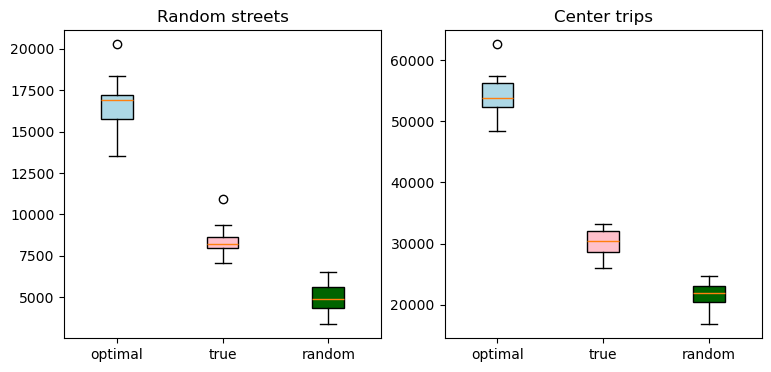

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

labels = ['optimal', 'true', 'random']

# rectangular box plot
bplot1 = ax1.boxplot([oh_rt, th_rt, rh_rt],
                     vert=True,  
                     patch_artist=True,  
                     labels=labels)  
ax1.set_title('Random streets')

# rectangular box plot
bplot2 = ax2.boxplot([oh_ct, th_ct, rh_ct],
                     vert=True,  
                     patch_artist=True, 
                     labels=labels) 
ax2.set_title('Center trips')

# fill with colors
colors = ['lightblue', 'pink', 'darkgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# Traffic demand proportional to the flows

In [24]:
fdf = pd.read_csv('flussi_per_simulazione.csv')[['CODSEC_ORIG', 'CODSEC_DEST', 'flows_car_aggr', 'flows_pae_aggr']]

In [25]:
# starting point must have and hub
no_flow = []

for idx, row in fdf.iterrows():
    hub_list = hubs[hubs['CODSEC'] == row['CODSEC_ORIG']]
    if len(hub_list) == 0:
        no_flow.append(idx)

th_fdf = fdf.drop(no_flow, axis = 0)

In [26]:
sums = th_fdf[['flows_car_aggr', 'flows_pae_aggr']].sum(axis=0)
th_fdf['flows_car_aggr'] = th_fdf['flows_car_aggr']/sums['flows_car_aggr']
th_fdf['flows_pae_aggr'] = th_fdf['flows_pae_aggr']/sums['flows_pae_aggr']

In [ ]:
def create_demand_flows(hubs, flows, n = 100):
    # city center information
    city_center = (4.70110, 50.87993)
    x_c, y_c = net.convertLonLat2XY(city_center[0], city_center[1])
    candidates_center = net.getNeighboringEdges(x_c, y_c, r=25, includeJunctions=True)
    e_center = sorted(candidates_center, key = lambda x: x[1])[0][0].getID()

    i = 0
    random_destination = ''
    center_destination = ''

    print('start generation phase...', end='')
    
    while i < n:
        
        #draw the starting point using the flows
        start_zone, flow = th_fdf.sample(weights=th_fdf['flows_car_aggr'])[['CODSEC_ORIG', 'flows_car_aggr']].values[0]
        #get a random mobility hub -- starting point in the
        random_hub = hubs[hubs['CODSEC'] == start_zone].sample(1)       
        #nearest neighbouring edge of the origin
        origin = random_hub['Edge'].values[0]

        #select one zone of its neighbor zone
        neighbors = zones_leuven[zones_leuven['CODSEC'] == start_zone]['adjacent'].values[0]
        dest_zone = np.random.choice(neighbors)

        #destination point 1 -- random street in another zone
        destination = road_net[road_net['CODSEC'] == dest_zone].sample(1)['id'].values[0]
        random_destination += '<flow id = "r'+str(i)+'" begin="0" end="100" departLane="random" number="20" from = "'+origin+'" to = "'+destination+'" type="type1"></flow> \n'

        #destination point2 -- city center
        center_destination += '<flow id = "c'+str(i)+'" begin="0" end="100" departLane="random" number="20" from = "'+origin+'" to = "'+e_center+'" type="type1"></flow> \n'
        
        i +=1

    
    print('end')
    print('start writing file...', end='')
    # write the file
    f = open("Sumo/proportional_traffic_demand.xml", "w")
    f.write('<?xml version="1.0" encoding="UTF-8"?> <routes> <vType id="type1" length="5.00" maxSpeed="70.00" accel="2.6" decel="4.5" sigma="0.5" /> \n')
    f.write(random_destination)
    f.write(center_destination)
    f.write('</routes>')
    f.close()
    print('end')